In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import set_param_freq
from toolbox.symbolic_SINDy import symbolic_SINDy

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


#### Case $\mu$, $A$ fixed and $\omega$ varying
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x}_0 = \mu x_0 - x_1 - \mu x_0 x_1^2 + A\sin(\omega x_1^2) \\
\dot{x}_1 = x_0
\end{cases}
$$
and with $\mu=1$, $A=1$ fixed, and $\omega \in [1,\pi]$.

In [2]:
# Select ODE & settings:
ode_name = 'OscilVdpODE_par_w' # help="name of the ode", type=str
ode_param = None # '1.,1.,1.' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
freq_SR = 10 # help="number of trajectories", type=int, default=100
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 103 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [3]:
# # Generate data:
# X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
# print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
# print(feature_names)

# # Save data:
# file_path = 'saved/data/oscillatingVdpODE_par_w_data.pkl'
# os.makedirs(os.path.dirname(file_path), exist_ok=True)
# with open(file_path, 'wb') as f:
#     dill.dump((X_list, dX_list, param_list, feature_names), f)

In [3]:
# Uploda data:
file_path = 'saved/data/oscillatingVdpODE_par_w_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 100, 2) (50, 100, 2) (50, 100)
['X0', 'X1', 'X2']


In [4]:
# Symbolic-SINDy call and fit
model = symbolic_SINDy(SR_method='SR-T', 
                       x_id=0,
                       degree=3,
                       threshold=0.1,
                       product=False)
final_model, building_blocks_lambda, _, _, _, _ =  model.call_param(X_list=X_list, dX_list=dX_list, param_list=param_list,
           feature_names=feature_names, dt=dt, building_blocks_lambda=None, 
           function_names=None, patience=0, lazy=False, ode=ode, ode_name=ode_name,
           ode_param=ode_param, freq_SR=freq_SR, n_sample=n_sample, 
           noise_ratio=noise_ratio, seed=seed, n_seed=n_seed, 
           T0=0, T=T, dim_x=dim_x, dim_k=dim_k)


Searching for additonal building blocks -> SR-T call:

Running with: ode_name=OscilVdpODE_par_w, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=103, n_seed=1
Dataset shape:  (101, 50, 3)
Functions set:  {'neg': 1, 'mul': 2, 'log': 1, 'add': 1, 'sub': 1, 'sin': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.44      6.75748e+10        4         0.895861         0.878455      1.97m
   1     5.75          61997.5        8         0.770376         0.743647      1.92m
   2     3.32          78.5026        8         0.767186         0.772359      2.41m
   3     4.53          306.047        8         0.761314         0.825201      2.02m
   4     5.39          16028.7       10         0.755759          0.78254      1.24m
   5     6.16          475.061   

#### Plot per report

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    # =======================
    # STYLE
    # =======================
    plt.rcdefaults()

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux + dt, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # =======================
    # TRUE TRAJECTORIES
    # =======================
    dg_true = data.DataGenerator(
        ode, T_aux, freq, n_sample,
        noise_sigma=0.,
        init_high=init_high,
        init_low=init_low
    )
    xt_true = dg_true.xt

    # =======================
    # ESTIMATED TRAJECTORIES
    # =======================
    pred_0_list = []

    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        test_params = np.tile(correct_param, (T_plot, 1))

        if dim_k != 0:
            pred_0 = model.simulate(
                xt_true[0, i, :-dim_k],
                t=t[:T_plot],
                u=test_params
            )
        else:
            pred_0 = model.simulate(
                xt_true[0, i],
                t=t[:T_plot]
            )

        pred_0_list.append(pred_0)

    # =======================
    # RESHAPE
    # =======================
    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]

    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]

    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    # =======================
    # PLOTTING
    # =======================
    if n_sample == 1:

        # ---------- dim_x = 1 ----------
        if dim_x == 1:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4))

            ax.plot(time_vector, pred_0_list,
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(time_vector, xt_true,
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(time_vector[0], xt_true[0],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(time_vector[-1], xt_true[-1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel(r"$t$")
            ax.set_ylabel(r"$x(t)$")

            if title:
                ax.set_title(title)

            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9, frameon=False, loc='lower right')

            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 2 (PHASE SPACE) ----------
        elif dim_x == 2:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4.3))

            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0], xt_true[:, 1],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel(r"$x_1$")
            ax.set_ylabel(r"$x_2$")

            if title:
                ax.set_title(title)

            ax.grid(True, alpha=0.3)
            ax.legend(
            fontsize=9,
            loc='lower right',
            frameon=True,
            framealpha=0.8,
            facecolor='white',
            edgecolor='0.8'
            )


            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 3 ----------
        else:

            fig, ax = plt.subplots(
                figsize=(6, 6),
                subplot_kw={'projection': '3d'}
            )

            ax.plot(pred_0_list[:, 0],
                    pred_0_list[:, 1],
                    pred_0_list[:, 2],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0],
                    xt_true[:, 1],
                    xt_true[:, 2],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1], xt_true[0, 2],
                       s=30, color='green', label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1], xt_true[-1, 2],
                       s=30, color='red', label='End')

            ax.set_xlabel(r"$x$")
            ax.set_ylabel(r"$y$")
            ax.set_zlabel(r"$z$")

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False, loc='lower right')
            plt.tight_layout()
            plt.show()


Best Model RMSE:  0.20161000445747596


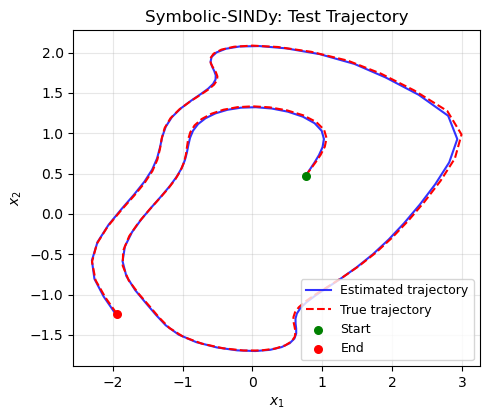

In [6]:
# Evaluation: within the training -> RMSE and reconstruction
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(final_model, ode, freq, n_test, [1., 1., np.pi], [0., 0., 1], dim_k)
print('Best Model RMSE: ', rmse)

evaluate_sample = 1
ics = [0.7, 0.4, 2.5]
title = 'Symbolic-SINDy: Test Trajectory'
evaluate_traj(final_model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=10)

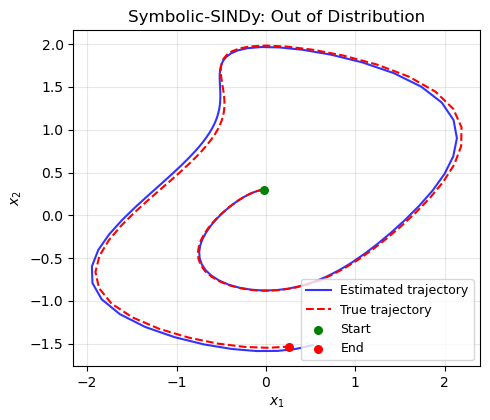

In [7]:
# Evaluation: outside the training set
evaluate_sample = 1
ics = [0, 0.3, 0.8]
title = 'Symbolic-SINDy: Out of Distribution'
evaluate_traj(final_model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=10)

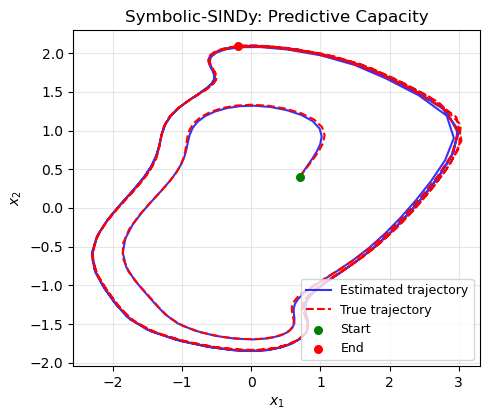

In [8]:
# Evaluation: Generalization for unseen time
evaluate_sample = 1
ics = [0.7, 0.4, 2.5]
title = 'Symbolic-SINDy: Predictive Capacity'
evaluate_traj(final_model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=20)

### UQ on the model

In [ ]:
# seed = 103 -> modello corretto
# seed = 109 -> piu frequente modello sbagliato

In [11]:
# Symbolic-SINDy call and fit
model = symbolic_SINDy(SR_method='SR-T', 
                       x_id=0,
                       degree=3,
                       threshold=0.1,
                       product=False)

model.fit(X_list=X_list, dX_list=dX_list, param_list=param_list,
          feature_names=feature_names, dt=dt, ode=ode, ode_name=ode_name,
          ode_param=ode_param, freq_SR=freq_SR, n_sample=n_sample, 
          noise_ratio=noise_ratio, seed=109, n_seed=n_seed, 
          T0=0, T=T, dim_x=dim_x, dim_k=dim_k)

Fitting Smart-SINDy model with control parameters

Searching for additonal building blocks -> SR-T call:

Running with: ode_name=OscilVdpODE_par_w, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=109, n_seed=1
Dataset shape:  (101, 50, 3)
Functions set:  {'neg': 1, 'mul': 2, 'log': 1, 'add': 1, 'sub': 1, 'sin': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.67      5.38753e+10        6         0.886781         0.830474      2.57m
   1     5.30          446.008        9         0.867166         0.866935      1.43m
   2     3.51          245.375        7         0.847401         0.778722      1.25m
 
promising programs:
sub(sin(add(X0, X1)), X1)
sub(sin(add(X0, X1)), X1)
sub(sin(add(X0, X1)), X1)
sub(sin(add(X0, X1)), X1)
sub(sin(add(X0, X1)), X1)
n

In [12]:
model.ensemble(X_list=X_list, dX_list=dX_list, param_list=param_list,
               feature_names=feature_names, dt=dt, n_models=200)

0.48578946917041593
0.5674806160088136
0.004539702895396148
0.7622204991037008
0.6047656978860216
0.18690261503740502
0.2359486580645929
0.48427257951326713
0.25032449158037595
0.6491309895059821
0.3991225794264052
0.0651589016160484
0.1137966655376278
0.07305678432637212
0.1814017953438405
0.09752917148599025
0.11157518183419886
0.09845910894728999
0.0979902129147613
0.15450966868871563
0.08156135836975842
0.5982319389076958


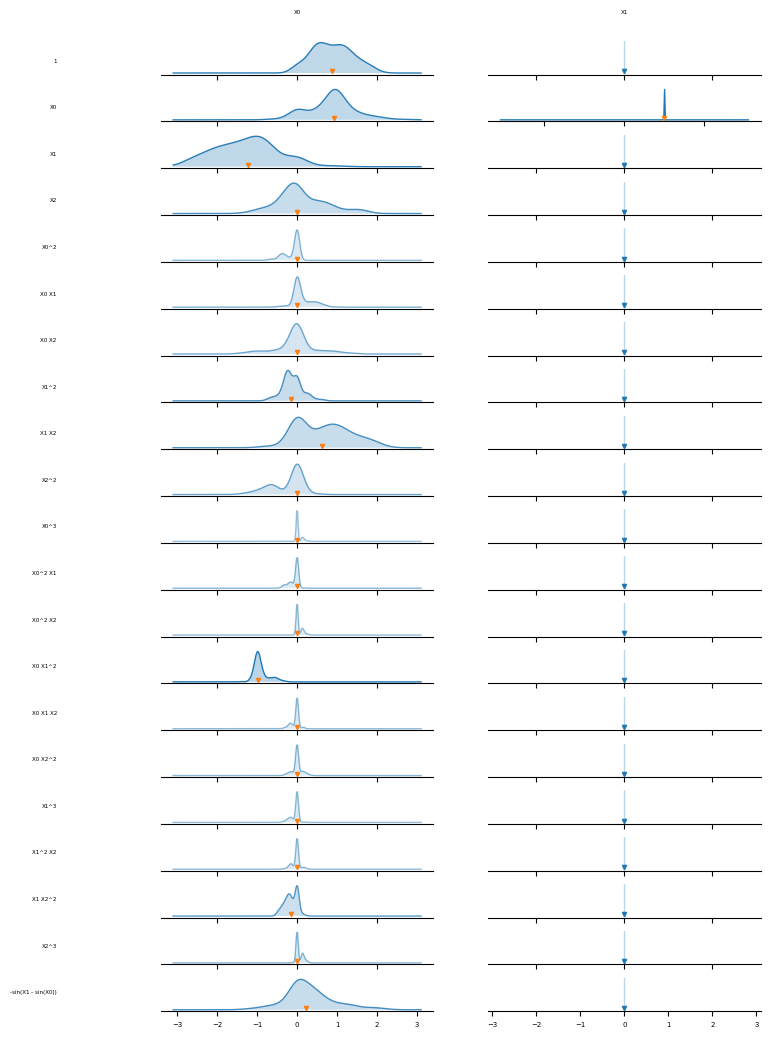

In [13]:
eps_var = 1e-14
from scipy.stats import gaussian_kde

coef_list = np.array(model.coef_list)  # (n_models, n_states, n_features)
n_models, n_states, n_features = coef_list.shape
lib = model.model.get_feature_names()
coef_median = np.median(coef_list, axis=0)  # (n_states, n_features)

# Frequenza di inclusione dei termini
inclusion = np.mean(coef_list != 0, axis=0)  # (n_states, n_features)

# Filtro: se tutti gli stati di una feature sono nulli -> non plottarla
var_per_feature = np.var(coef_list, axis=0)  # (n_states, n_features)
valid_features_mask = np.any(var_per_feature > eps_var, axis=0)
valid_features_idx = np.where(valid_features_mask)[0]

lib_valid = [lib[i] for i in valid_features_idx]
coef_median_valid = coef_median[:, valid_features_idx]
n_features_valid = len(valid_features_idx)

# Plot
fig, axes = plt.subplots(
    n_features_valid,
    n_states,
    figsize=(4 * n_states, 0.6 * n_features_valid),
    squeeze=False
)

# Range comune
global_ran = np.max(np.abs(coef_list[:, :, valid_features_idx])) + 0.2
x_common = np.linspace(-global_ran, global_ran, 300)

for idx_plot, f in enumerate(valid_features_idx):
    for s in range(n_states):
        ax = axes[idx_plot, s]
        coeff = coef_list[:, s, f]
        inc = inclusion[s, f]
        alpha_val = 0.3 + 0.7 * inc

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])

        var = np.var(coeff)

        if var > eps_var:
            try:
                std = np.std(coeff)
                print(std)
                if std > 0:
                    # Bandwidth adattiva alla dispersione (Soluzione 3)
                    kde = gaussian_kde(coeff)
                    y_vals = kde(x_common)

                    ax.plot(x_common, y_vals, linewidth=1, alpha=alpha_val)
                    ax.fill_between(x_common, y_vals, alpha=0.3 * alpha_val)
                else:
                    # Caso completamente degenere (fallback)
                    c = float(np.mean(coeff))
                    ax.axvline(c, 0, 1, linewidth=1, alpha=alpha_val)

            except Exception:
                pass

        else:
            c = float(np.mean(coeff))
            ax.axvline(c, 0, 1, linewidth=1, alpha=alpha_val)
            ax.set_xlim(-global_ran, global_ran)
            ax.set_ylim(-0.05, 1.2)

        # Mediana (triangolino)
        median_val = coef_median[s, f]
        ax.plot(
            median_val, 0.1,
            marker='v',
            markersize=3,
            transform=ax.get_xaxis_transform()
        )

        # Tick solo ultima riga
        if idx_plot < n_features_valid - 1:
            ax.set_xticklabels([])
        else:
            ax.tick_params(axis='x', labelsize=5)

# Titoli colonne (stati)
if feature_names is None:
    feature_names = [f"State {i}" for i in range(n_states)]

for s in range(n_states):
    axes[0, s].set_title(feature_names[s], fontsize=4, pad=20)

# === Etichette della libreria (fig.text) ===
for idx_plot, f in enumerate(valid_features_idx):
    pos = axes[idx_plot, 0].get_position()
    y_center = pos.y0 + pos.height / 2

    fig.text(
        0.02, y_center,
        lib[f],
        va='center',
        ha='right',
        fontsize=4
    )

# Spaziatura finale
plt.subplots_adjust(left=0.15, hspace=0.4, wspace=0.2)

plt.savefig("vdp_bad.png", dpi=300, bbox_inches="tight")
plt.show()
